# Проект: предсказание конечной температуры сплава

Для оптимизацции производственных расходов, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

**Задача — построить модель, которая будет предсказывать температуру сплава (критерий успеха: `MAE` < 6.8).**

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- **`data_arc_new.csv`** — данные об электродах:
    - `key` — номер партии;
    - `Начало нагрева дугой` — время начала нагрева;
    - `Конец нагрева дугой` — время окончания нагрева;
    - `Активная мощность` — значение активной мощности;
    - `Реактивная мощность` — значение реактивной мощности;


- **`data_bulk_new.csv`** — данные о подаче сыпучих материалов (объём):
    - `key` — номер партии;
    - `Bulk 1` … `Bulk 15` — объём подаваемого материала;


- **`data_bulk_time_new.csv`** — данные о подаче сыпучих материалов (время):
    - `key` — номер партии;
    - `Bulk 1` … `Bulk 15` — время подачи материала;


- **`data_gas_new.csv`** — данные о продувке сплава газом:
    - `key` — номер партии;
    - `Газ 1` — объём подаваемого газа;


- **`data_temp_new.csv`** — результаты измерения температуры:
    - `key` — номер партии;
    - `Время замера` — время замера;
    - `Температура` — значение температуры;


- **`data_wire_new.csv`** — данные о проволочных материалах (объём):
    - `key` — номер партии;
    - `Wire 1` … `Wire 9` — объём подаваемых проволочных материалов;


- **`data_wire_time_new.csv`** — данные о проволочных материалах (время):
    - `key` — номер партии;
    - `Wire 1` … `Wire 9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

В проекте будет несколько блоков:
1. загрузка данных и изучение общей информации;
2. исследовательский анализ и предобработка данных;
3. объединение данных;
4. исследовательский анализ и предобработка данных объединённого датафрейма;
5. подготовка данных;
6. обучение моделей машинного обучения;
7. выбор лучшей модели;
8. общий вывод и рекомендации заказчику.

## Загрузка данных и изучение общей информации

Для начала работы импортируем все необходимые в проекте библиотеки:

In [1]:
! pip install phik -q

In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

Создадим функцию для чтения csv-файлов:

In [3]:
# функция для чтения csv-файлов
def read_df (title):
    # title - название файла
    
    pth = '/datasets/' + str(title) + '.csv'
    
    # считываем данные и сохраняем в переменную
    if os.path.exists(pth):
        title = pd.DataFrame(pd.read_csv(pth))
    else:
        print(f'При считывании {title} произошла ошибка')
        
    return title

Загрузим данные, посмотрим на них, а также выведем информацию о датафреймах:

In [4]:
# Загрузка датафреймов
data_arc_new = read_df('data_arc_new')
data_bulk_new = read_df('data_bulk_new')
data_bulk_time_new = read_df('data_bulk_time_new')
data_gas_new = read_df('data_gas_new')
data_temp_new = read_df('data_temp_new')
data_wire_new = read_df('data_wire_new')
data_wire_time_new = read_df('data_wire_time_new')

In [5]:
# создание словаря с названиями датафреймов
title_df = {'data_arc_new': data_arc_new, 
            'data_bulk_new': data_bulk_new, 
            'data_bulk_time_new': data_bulk_time_new, 
            'data_gas_new': data_gas_new, 
            'data_temp_new': data_temp_new, 
            'data_wire_new': data_wire_new, 
            'data_wire_time_new': data_wire_time_new}

In [6]:
# просмотр первых 5 строк датафреймов и информации о них
for key, df in title_df.items():
    print(f'Датафрейм: {key}')
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')
    print(f'Количестов уникальных партий: {df["key"].nunique()}')
    display(df.head(6))
    display(df.describe(include='all'))
    display(df.info())

Датафрейм: data_arc_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3214


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-07-26 14:47:27,2019-09-01 01:16:07,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Датафрейм: data_bulk_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3129


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Датафрейм: data_bulk_time_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3129


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-06-14 12:55:26,2019-08-13 02:46:14,2019-06-06 16:45:59,2019-05-08 13:47:21,2019-05-12 13:06:07,2019-05-06 01:12:46,2019-07-20 19:54:13,2019-07-08 17:14:53,2019-05-14 16:39:17,2019-07-28 10:36:29,2019-07-19 20:59:43,2019-05-08 13:47:21,2019-05-11 08:18:48,2019-05-24 15:58:28,2019-05-16 17:38:00
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Датафрейм: data_gas_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3239


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Датафрейм: data_temp_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3216


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


,key,Время замера,Температура
count,18092.000000,18092,14665.000000
unique,NaN,18092,NaN
top,NaN,2019-05-25 20:08:42,NaN
freq,NaN,1,NaN
mean,1616.460977,NaN,1590.722741
std,934.641385,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,807.750000,NaN,1580.000000
50%,1618.000000,NaN,1590.000000
75%,2429.000000,NaN,1599.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Датафрейм: data_wire_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3081


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Датафрейм: data_wire_time_new
Количество явных дубликатов: 0
Количестов уникальных партий: 3081


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-05-23 21:57:16,2019-06-09 09:54:01,2019-09-01 12:41:21,2019-08-12 19:51:09,2019-08-13 06:14:30,2019-07-28 19:46:20,2019-08-12 21:48:11,2019-05-14 15:07:59,2019-06-09 19:55:31
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Вывод по блоку:

- во всех датафреймах с датами не корректный тип данных в столбцах со временем;
- в датафреймах с данными о сыпучих и проволочных материалах много пропусков, их в дальнейшем необходимо будет заполнить нулями;
- названия столбцов необходимо будет привести к общепринятому змеиному регистру;
- явных дулбикатов нет;
- количество уникальных партий во всех датафреймах различается, за исключением парных датафреймов с объемом и временем;
- в `data_arc_new`:
	- есть странное значение реактивной мощности (большое отрицательное значение), его нужно будет как-то обработать;
	- пропусков нет;
- в `data_bulk_new` и `data_bulk_time_new`:
	- количество пропусков совпадает;
	- нет отрицательных значений;
- в `data_gas_new`:
	- пропусков нет;
- в `data_temp_new`:
	- в столбце с температурой есть порядка 20% пропусков, учитывая, что это целевой признак, заполнять их каким-либо значением будет ошибкой;
	- нет отрицательных значений;
- в `data_wire_new` и `data_wire_time_new`:
	- количество пропусков совпадает;
	- нет отрицательных значений.

## Исследовательский анализ и предобработка данных

Для начала приведем названия столбцов к змеиному регистру:

In [7]:
# переименование рускоязычных столбцов
data_arc_new.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']
data_gas_new.columns = ['key', 'gas']
data_temp_new.columns = ['key', 'time', 'temp']

In [8]:
# функция для изменения англоязычного названия столбца на змеиный регистр
def to_snake(df):
    # df - датафрейм
    
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    return df.columns

In [9]:
# переименование англоязычных столбцов
data_bulk_new.columns = to_snake(data_bulk_new)
data_bulk_time_new.columns = to_snake(data_bulk_time_new)
data_wire_new.columns = to_snake(data_wire_new)
data_wire_time_new.columns = to_snake(data_wire_time_new)

In [10]:
# проверка корректности переименования
for key, df in title_df.items():
    print(f'Названия столбцов в датафрейме {key}\n {df.columns}\n')

Названия столбцов в датафрейме data_arc_new
 Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')

Названия столбцов в датафрейме data_bulk_new
 Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Названия столбцов в датафрейме data_bulk_time_new
 Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Названия столбцов в датафрейме data_gas_new
 Index(['key', 'gas'], dtype='object')

Названия столбцов в датафрейме data_temp_new
 Index(['key', 'time', 'temp'], dtype='object')

Названия столбцов в датафрейме data_wire_new
 Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_

Все прошло успешно, теперь изменим тип данных на `datetime`, там где это необходимо:

In [11]:
# изменений типа данных на datetime
data_arc_new[['start_heating', 'end_heating']] = data_arc_new[['start_heating', 'end_heating']].apply(pd.to_datetime)

data_temp_new['time'] = pd.to_datetime(data_temp_new['time'])

data_bulk_time_new[[f'bulk_{x}' for x in range(1,16)]] = \
data_bulk_time_new[[f'bulk_{x}' for x in range(1,16)]].apply(pd.to_datetime)

data_wire_time_new[[f'wire_{x}' for x in range(1,10)]] = \
data_wire_time_new[[f'wire_{x}' for x in range(1,10)]].apply(pd.to_datetime)

In [12]:
# проверка корректности замены типа данных
for df in data_arc_new, data_temp_new, data_bulk_time_new, data_wire_time_new:
    display(df.dtypes)

key                        int64
start_heating     datetime64[ns]
end_heating       datetime64[ns]
active_power             float64
reactive_power           float64
dtype: object

key              int64
time    datetime64[ns]
temp           float64
dtype: object

key                 int64
bulk_1     datetime64[ns]
bulk_2     datetime64[ns]
bulk_3     datetime64[ns]
bulk_4     datetime64[ns]
bulk_5     datetime64[ns]
bulk_6     datetime64[ns]
bulk_7     datetime64[ns]
bulk_8     datetime64[ns]
bulk_9     datetime64[ns]
bulk_10    datetime64[ns]
bulk_11    datetime64[ns]
bulk_12    datetime64[ns]
bulk_13    datetime64[ns]
bulk_14    datetime64[ns]
bulk_15    datetime64[ns]
dtype: object

key                int64
wire_1    datetime64[ns]
wire_2    datetime64[ns]
wire_3    datetime64[ns]
wire_4    datetime64[ns]
wire_5    datetime64[ns]
wire_6    datetime64[ns]
wire_7    datetime64[ns]
wire_8    datetime64[ns]
wire_9    datetime64[ns]
dtype: object

Все успешно.

Теперь создадим функцию для проведения анализа данных:

In [13]:
# функция для анализа данных
def analysis (df, df_title, bar):
    # df - датафрейм
    # df_title - название датафрейма
    # bar - нужна ли столбчатая диаграмма количества добавок yes/no
    
    df = df.drop('key', axis=1)
    
    try:
        number = df.select_dtypes('number')
        datetime = df.select_dtypes('datetime')
    except:
        print('Нет нужных данных')
    
    # построение столбчатой диаграммы количества добавок
    if bar == 'yes':
        number.count().plot(kind='bar', figsize=(12, 7), grid=True)
        plt.title('Диаграмма количества добавок', fontsize=20)
        plt.ylabel('Количество', fontsize=15)
        plt.xlabel('Добавка', fontsize=15)
        plt.show()
    elif bar == 'no':
        pass
    else:
        print('Низвестное значение третьего параметра функции')
    
    if datetime.empty:
        pass
    else:
        share_pass = datetime.isnull().sum() / len(datetime)
        min_data = datetime.min()
        max_data = datetime.max()
        data = {'Доля пропусков': share_pass, 'Самая раняя дата': min_data, 'Самая поздняя дата': max_data}
        descr = pd.DataFrame(data)
        
        print(f'Анализ временных данных в датафрейме: {df_title}')
        display(descr)
    
    if number.empty:
        pass
    else:
        share_pass = number.isnull().sum() / len(number)
        min_data = number.min()
        max_data = number.max()
        data = {'Доля пропусков': share_pass, 'Самое низкое значение': min_data, 'Самое высокое значение': max_data}
        descr = pd.DataFrame(data)
        
        print(f'Анализ количественных данных в датафрейме: {df_title}')
        display(descr)
        
        print(f'\n Гистограммы и диаграммы размаха количественных признаков в {df_title}')
        
        # вычисление количества строк для фигуры
        nrows = len(number.select_dtypes('number').columns)
    
        # построение фигуры для графиков
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(18, 7*nrows))

        for i, parametr in enumerate(number.columns):
        
            if nrows == 1:
                ax_1 = axes[0]
                ax_2 = axes[1]
            else:
                ax_1 = axes[i, 0]
                ax_2 = axes[i, 1]                            
        
            # построение гистограммы
            number[parametr].hist(bins=20, grid=True, ax=ax_1)
            ax_1.set_ylabel('Количество', fontsize=15)
            ax_1.set_xlabel(f'Значение {parametr}', fontsize=15)
        
            # построение диаграммы размаха
            number.boxplot(column=parametr, ax=ax_2, vert=False)
            ax_2.set_ylabel('Параметр', fontsize=15)
            ax_2.set_xlabel(f'Значение {parametr}', fontsize=15)
        
        plt.show()

Подготовительные этапы закончились, теперь приступим непосредственно к анализу и предобработке данных.

### Данные об электродах

Посмотрим на анализ данных об электродах `data_arc_new`:

Анализ временных данных в датафрейме: data_arc_new


,Доля пропусков,Самая раняя дата,Самая поздняя дата
start_heating,0.0,2019-05-03 11:02:14,2019-09-06 17:24:54
end_heating,0.0,2019-05-03 11:06:02,2019-09-06 17:26:15


Анализ количественных данных в датафрейме: data_arc_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
active_power,0.0,0.223120,1.463773
reactive_power,0.0,-715.479924,1.270284



 Гистограммы и диаграммы размаха количественных признаков в data_arc_new


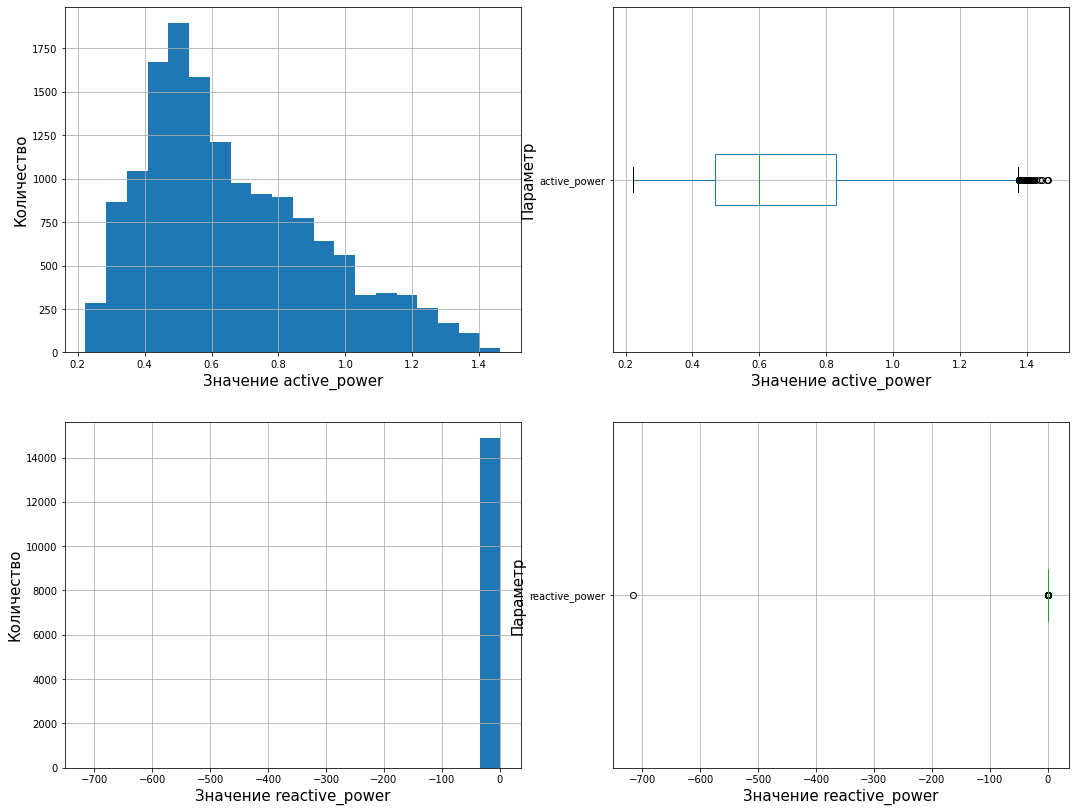

In [14]:
analysis(data_arc_new, 'data_arc_new', 'no')

Большое отрицательное значение реактивной энергии мешает посмотреть на ее распределение, посмотрим на эту партию:

In [15]:
# вычисление номера партии
key_neg_power = data_arc_new.sort_values(by='reactive_power').iloc[0]['key']

# вывод партии с большой отрицательной реактивной мощностью
data_arc_new.query('key == @key_neg_power')

,key,start_heating,end_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Удалять эту партию не хочется, попробуем заменить некорректное значение на реалистичное значение, но сначала добавим новые признаки:

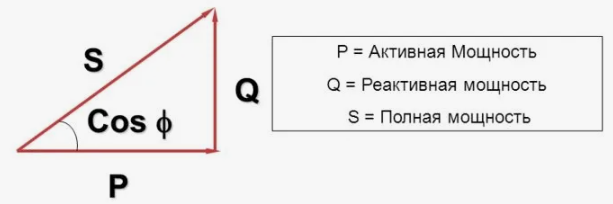

Для начала вычислим полную мощность `full_power`, как корень из суммы квадратов активной и реактивной мощности:

In [16]:
# создание нового признака full_power
data_arc_new['full_power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power']**2)**0.5

print(f'Количество пропусков в столбце full_power: {data_arc_new["full_power"].isnull().sum()}')

Количество пропусков в столбце full_power: 0


Пропусков нет, создание нового признака прошло успешно.

Теперь добавим еще один признак `cos_fi`, как отношение активной к полной мощности:

In [17]:
# создание нового признака cos_fi
data_arc_new['cos_fi'] = data_arc_new['active_power'] / data_arc_new['full_power']

print(f'Количество пропусков в столбце cos_fi: {data_arc_new["cos_fi"].isnull().sum()}')

Количество пропусков в столбце cos_fi: 0


Вычислим средний `cos_fi` трех циклов партии №2116 и подставим его в датафрейм, затем найдем и подставим полную мощность и наконец вычислим реактивную мощность:

In [18]:
# подстановка косинуса фи, полной и реактивной мощности
data_arc_new.at[9780, 'cos_fi'] = data_arc_new.query('key == @key_neg_power & cos_fi > 0.5')['cos_fi'].mean()
data_arc_new.at[9780, 'full_power'] = data_arc_new.iloc[9780]['active_power'] / data_arc_new.iloc[9780]['cos_fi']
data_arc_new.at[9780, 'reactive_power'] = (data_arc_new.iloc[9780]['full_power']**2 - 
                                           data_arc_new.iloc[9780]['active_power']**2)**0.5

In [19]:
data_arc_new.query('key == @key_neg_power')

,key,start_heating,end_heating,active_power,reactive_power,full_power,cos_fi
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881,1.049621,0.750317
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498,0.711362,0.815707
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.543892,0.890690,0.791907
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513,0.696114,0.809697


Теперь значения в мощности в партии №2116 выглядят корректными, создадим еще один новый признак, продолжительность нагрева `duration_heating`:

In [20]:
# создание нового признака duration_heating
data_arc_new['duration_heating'] = data_arc_new['end_heating'] - data_arc_new['start_heating']

# перевод продолжительности в секунды
data_arc_new['duration_heating'] = data_arc_new['duration_heating'].astype('timedelta64[s]').astype('int')

print(f'Количество пропусков в столбце duration_heating: {data_arc_new["duration_heating"].isnull().sum()}')

Количество пропусков в столбце duration_heating: 0


Пропусков нет

Добавим еще один признак, для снижения которого весь этот проект и направлен, энергию `energy`, который рассчитаем как произведение полной энергии `full_power` на продолжительность нагрева `duration_heating`:

In [21]:
# создание нового признака energy
data_arc_new['energy'] = data_arc_new['full_power'] * data_arc_new['duration_heating']

print(f'Количество пропусков в столбце energy: {data_arc_new["energy"].isnull().sum()}')

Количество пропусков в столбце energy: 0


Пропусков нет, посмотрим еще раз на анализ:

Анализ временных данных в датафрейме: data_arc_new


,Доля пропусков,Самая раняя дата,Самая поздняя дата
start_heating,0.0,2019-05-03 11:02:14,2019-09-06 17:24:54
end_heating,0.0,2019-05-03 11:06:02,2019-09-06 17:26:15


Анализ количественных данных в датафрейме: data_arc_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
active_power,0.0,0.223120,1.463773
reactive_power,0.0,0.153777,1.270284
full_power,0.0,0.275718,1.898158
cos_fi,0.0,0.707722,0.880503
duration_heating,0.0,11.000000,907.000000
energy,0.0,6.409531,1084.729420



 Гистограммы и диаграммы размаха количественных признаков в data_arc_new


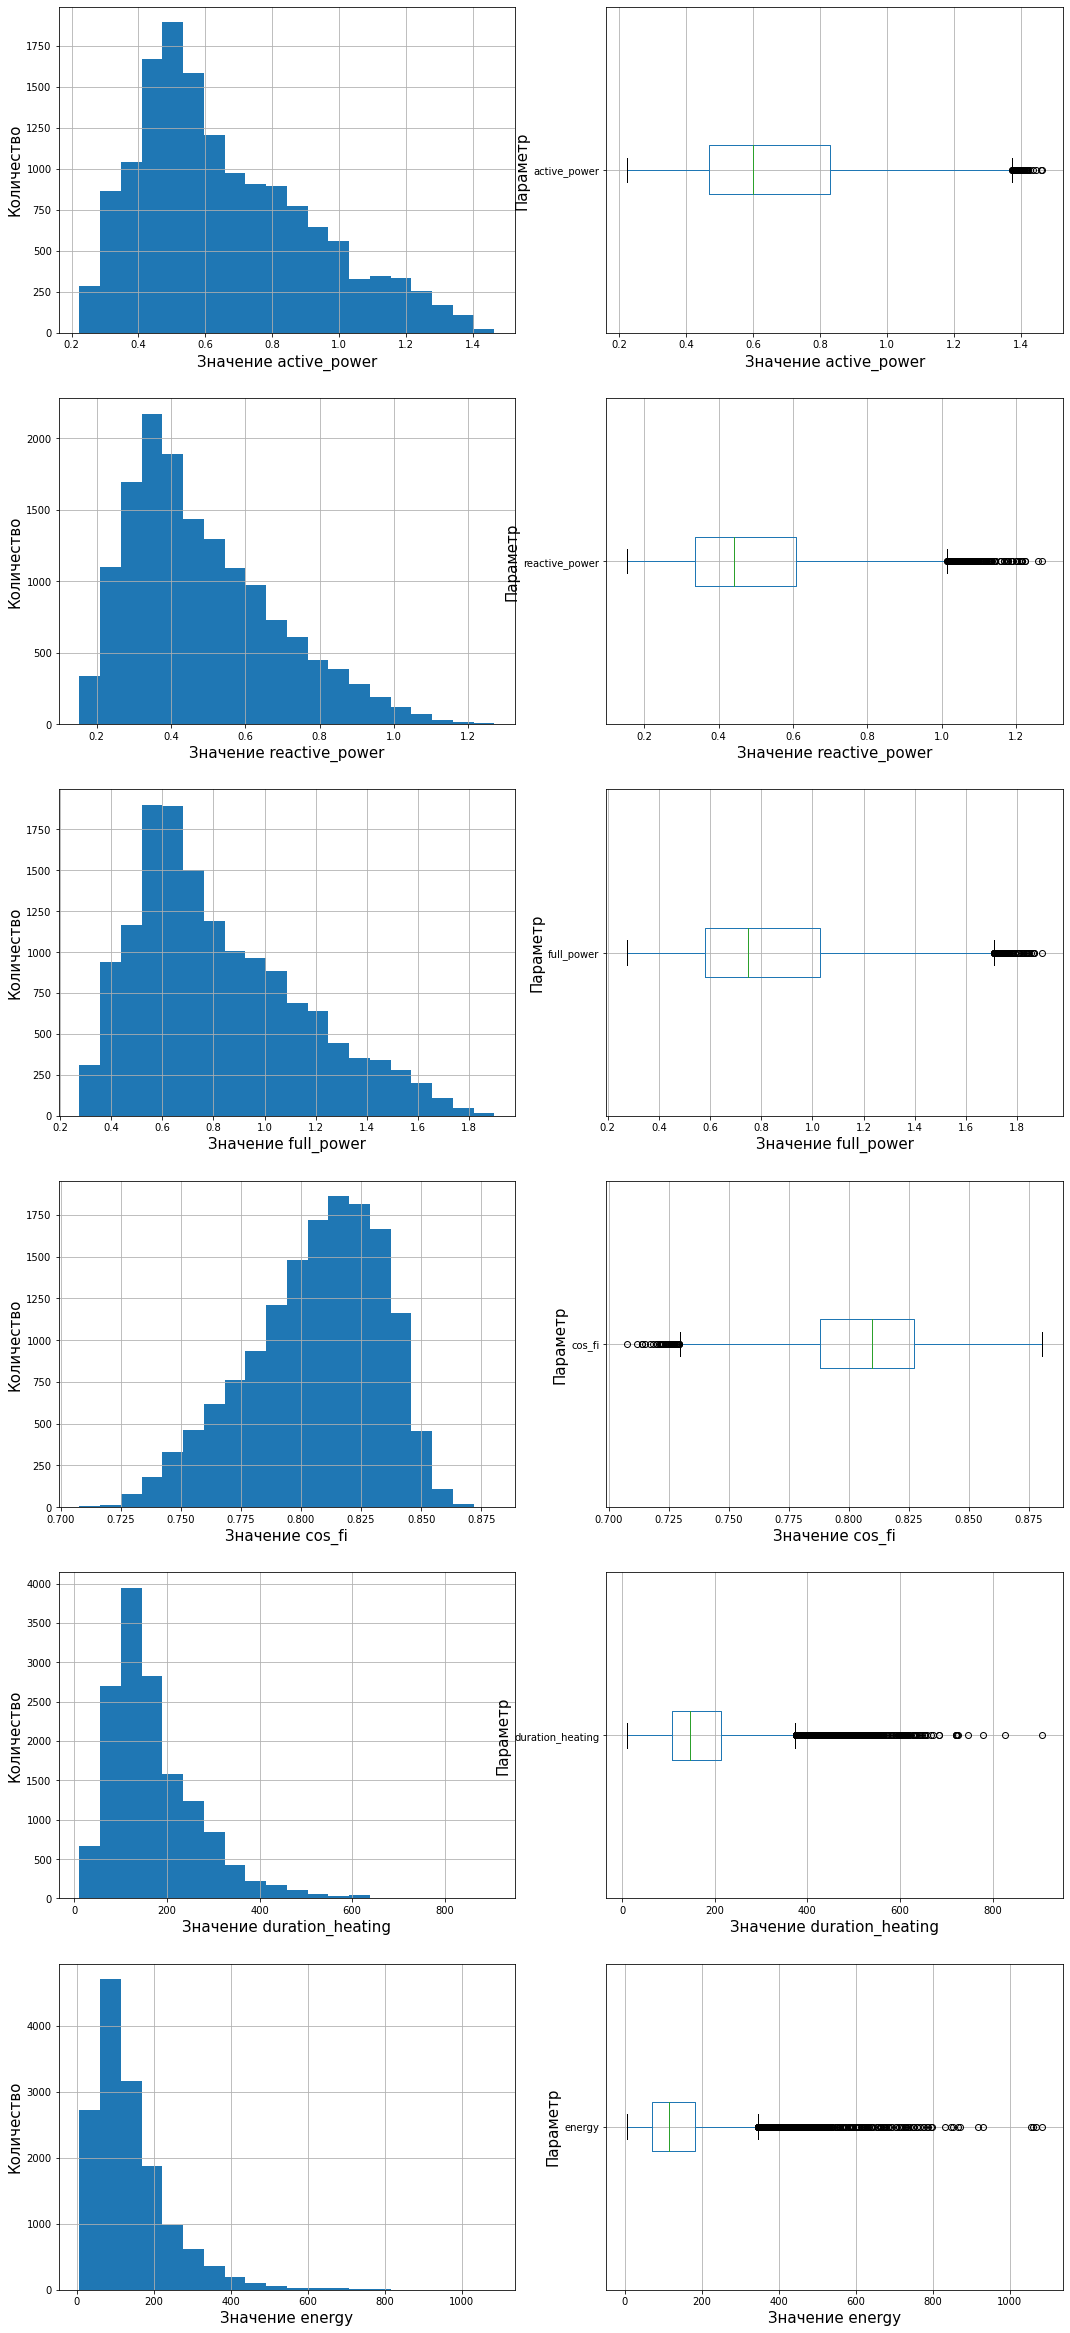

In [22]:
analysis(data_arc_new, 'data_arc_new', 'no')

Вывод:
- были добавлены новые признаки `full_power`, `cos_fi`, `duration_heating` и `energy`;
- пропусков в данных нет;
- в датафрейме данные партий с 3 мая 2019 по 6 сентября 2019;
- обработано аномальное значение в столбце `reactive_power`;
- на диаграммах размаха есть выбросы, но они не анамальны.

### Данные о подаче сыпучих материалов (объём)

Посмотрим на анализ данных о подаче сыпучих материалов (объём):

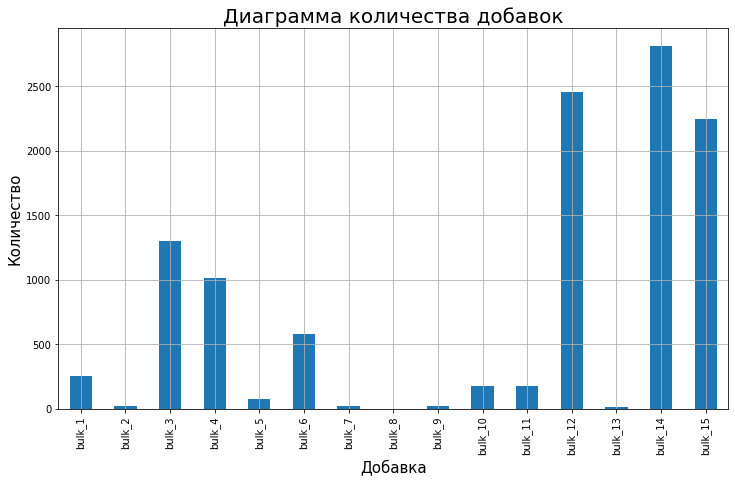

Анализ количественных данных в датафрейме: data_bulk_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
bulk_1,0.919463,10.0,185.0
bulk_2,0.992969,228.0,325.0
bulk_3,0.585171,6.0,454.0
bulk_4,0.675935,12.0,281.0
bulk_5,0.975391,11.0,603.0
bulk_6,0.815916,17.0,503.0
bulk_7,0.992010,47.0,772.0
bulk_8,0.999680,49.0,49.0
bulk_9,0.993928,63.0,147.0
bulk_10,0.943752,24.0,159.0



 Гистограммы и диаграммы размаха количественных признаков в data_bulk_new


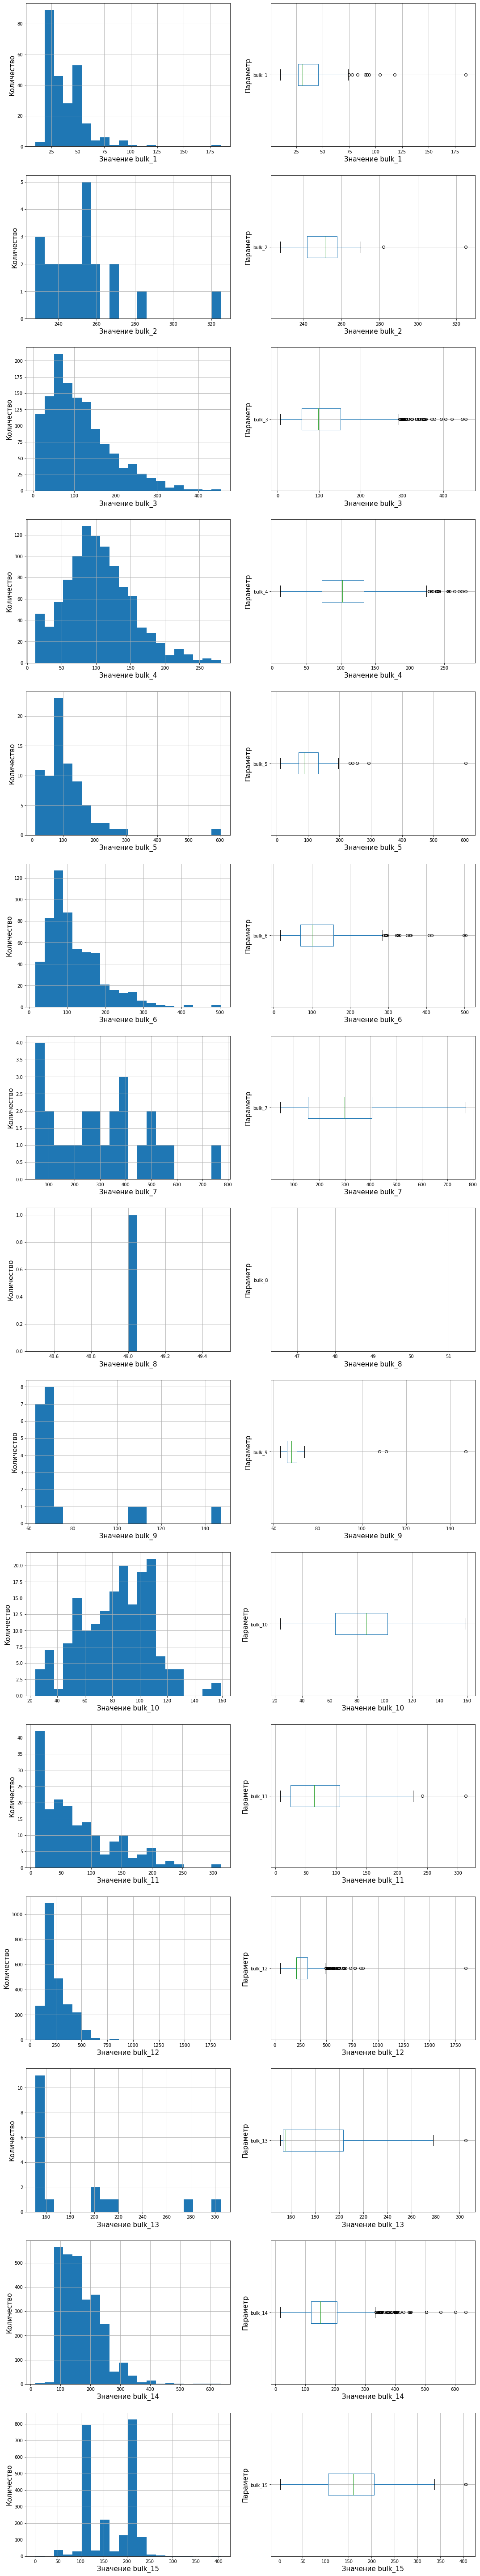

In [23]:
analysis(data_bulk_new, 'data_bulk_new', 'yes')

Много пропусков, заменим их нулями, т.к. остутсвие каких-либо данных в этом датафрейме означает, что этот материал не добавляли:

In [24]:
# заполнение пропусков нулями
data_bulk_new = data_bulk_new.fillna(0)

In [25]:
# вывод количества пропусков в столбцах
data_bulk_new.isnull().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

Пропусков нет.

Вывод:
- больше всего всыпают добавки `bulk_12`, `bulk_14` и `bulk_15`, добавки `bulk_3`, `bulk_4` и `bulk_6` всыпают уже меньше, остальные практически не засыпают;
- в добавках `bulk_5` и `bulk_12` возможно присутствуют выбросы, они больше предыдущего больше чем в два раза, но будем считать, что они корректны, возможно при финальном поиске аномалий их отбросит;
- обработаны пропуски.

### Данные о подаче сыпучих материалов (время)

Посмотрим на анализ данных о подаче сыпучих материалов (время):

In [26]:
analysis(data_bulk_time_new, 'data_bulk_time_new', 'no')

Анализ временных данных в датафрейме: data_bulk_time_new


,Доля пропусков,Самая раняя дата,Самая поздняя дата
bulk_1,0.919463,2019-05-03 17:42:46,2019-09-05 09:11:32
bulk_2,0.992969,2019-05-07 15:39:35,2019-08-13 11:47:39
bulk_3,0.585171,2019-05-03 20:40:25,2019-09-06 12:26:52
bulk_4,0.675935,2019-05-03 11:28:48,2019-09-05 03:35:21
bulk_5,0.975391,2019-05-07 15:19:17,2019-09-02 18:16:52
bulk_6,0.815916,2019-05-03 19:09:15,2019-09-06 16:24:28
bulk_7,0.992010,2019-05-07 18:11:01,2019-09-05 19:07:49
bulk_8,0.999680,2019-07-08 17:14:53,2019-07-08 17:14:53
bulk_9,0.993928,2019-05-14 11:57:58,2019-08-16 09:11:56
bulk_10,0.943752,2019-05-06 07:54:02,2019-09-04 10:03:22


Cоздадим новый признак `bulk_steel_grade`, обозначающий "условную" марку стали (1, 2, 3...) (марка стали - это уникальный набор добавок):

In [27]:
# функция для создания нового признака - "условная марка стали
def new_features (df):
    # df - датафрейм

    # создание маски датафрейма
    df = df.notnull()
    
    # создание уникальных сочетаний ячеек
    df = df.astype('str')
    df['new_features'] = df.drop('key', axis=1).agg(lambda x: ''.join(x.values), axis=1)
    
    # условная нумерация марок
    for i, name in enumerate(df['new_features'].unique(), 1):
        df['new_features'] = df['new_features'].replace(name, i)
    
    print(f'Количество уникальных марок стали: {df["new_features"].nunique()}')
    
    return df['new_features']

In [28]:
# создание нового признака bulk_steel_grade
data_bulk_time_new['bulk_steel_grade'] = new_features(data_bulk_time_new)

Количество уникальных марок стали: 143


In [29]:
print(f'Количество пропусков в столбце bulk_steel_grade: {data_bulk_time_new["bulk_steel_grade"].isnull().sum()}')

Количество пропусков в столбце bulk_steel_grade: 0


Пропусков в столбце с новым признаком нет.

Вывод:
- даты партий в тех же пределах, что и в `data_arc_new` с 3 мая 2019 по 6 сентября 2019;
- был создан новый признак марки стали `bulk_steel_grade`;
- пропуски заполнять нет необходимости, в дальнейшем будет использоваться только новый признак.

### Данные о продувке сплава газом

Посмотрим на анализ данных о продувке сплава газом:

Анализ количественных данных в датафрейме: data_gas_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
gas,0.0,0.008399,77.99504



 Гистограммы и диаграммы размаха количественных признаков в data_gas_new


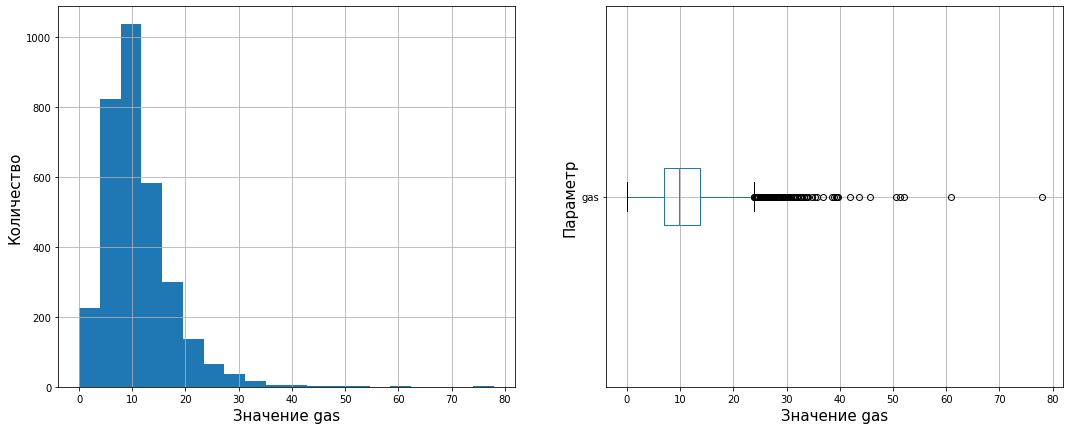

In [30]:
analysis(data_gas_new, 'data_gas_new', 'no')

Вывод:
- возможно присутствуют выбросы, но пока будем считать, что они корректны, возможно при финальном поиске аномалий их отбросит;
- пропусков нет.

### Результаты измерения температуры

Посмотрим на анализ данных о результатах измерения температуры:

Анализ временных данных в датафрейме: data_temp_new


,Доля пропусков,Самая раняя дата,Самая поздняя дата
time,0.0,2019-05-03 11:02:04,2019-09-06 17:30:05


Анализ количественных данных в датафрейме: data_temp_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
temp,0.189421,1191.0,1705.0



 Гистограммы и диаграммы размаха количественных признаков в data_temp_new


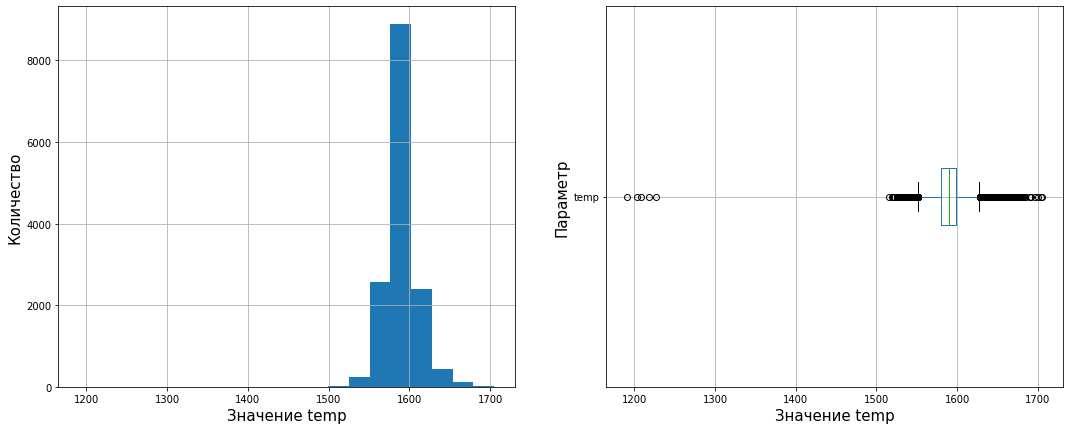

In [31]:
analysis(data_temp_new, 'data_temp_new', 'no')

Смущают низкие значения температуры, посмотрим на эти партии:

In [32]:
# вычисление номера партии
key_low_temp = list(data_temp_new.query('temp < 1300')['key'])

# вывод партии с низкой температурой
data_temp_new.query('key == @key_low_temp')

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0


Вывод:
- почти 19% пропусков замеров температуры (возможно были ошибки датчика или т.п.), заполнять их будет некорректно, т.к. из этих данных будет формироваться целевой признак;
- даты партий в тех же пределах, что и в `data_arc_new` с 3 мая 2019 по 6 сентября 2019;
- присутствуют выбросы (низкая температура только в первых замерах, может конечно и реально температура была низкая, но не настолько, потому что нагреть примерно 100 тонн металла с 1200 до 1600 градусов за 5-15 минут выглядит невозможным), далее при объединении датафреймов уберем эти партии.

### Данные о проволочных материалах (объём)

Посмотрим на анализ данных о проволочных материалах (объём):

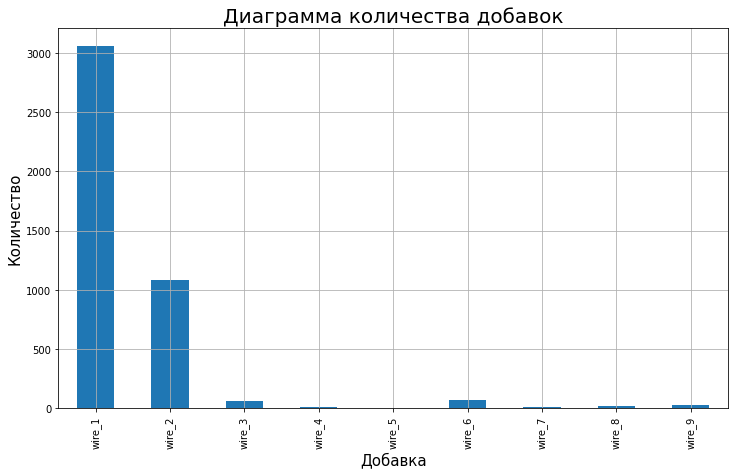

Анализ количественных данных в датафрейме: data_wire_new


,Доля пропусков,Самое низкое значение,Самое высокое значение
wire_1,0.008439,1.918800,330.314424
wire_2,0.649789,0.030160,282.780152
wire_3,0.979552,0.144144,385.008668
wire_4,0.995456,24.148801,113.231044
wire_5,0.999675,15.132000,15.132000
wire_6,0.976306,0.034320,180.454575
wire_7,0.996430,0.234208,32.847674
wire_8,0.993833,45.076721,102.762401
wire_9,0.990587,4.622800,90.053604



 Гистограммы и диаграммы размаха количественных признаков в data_wire_new


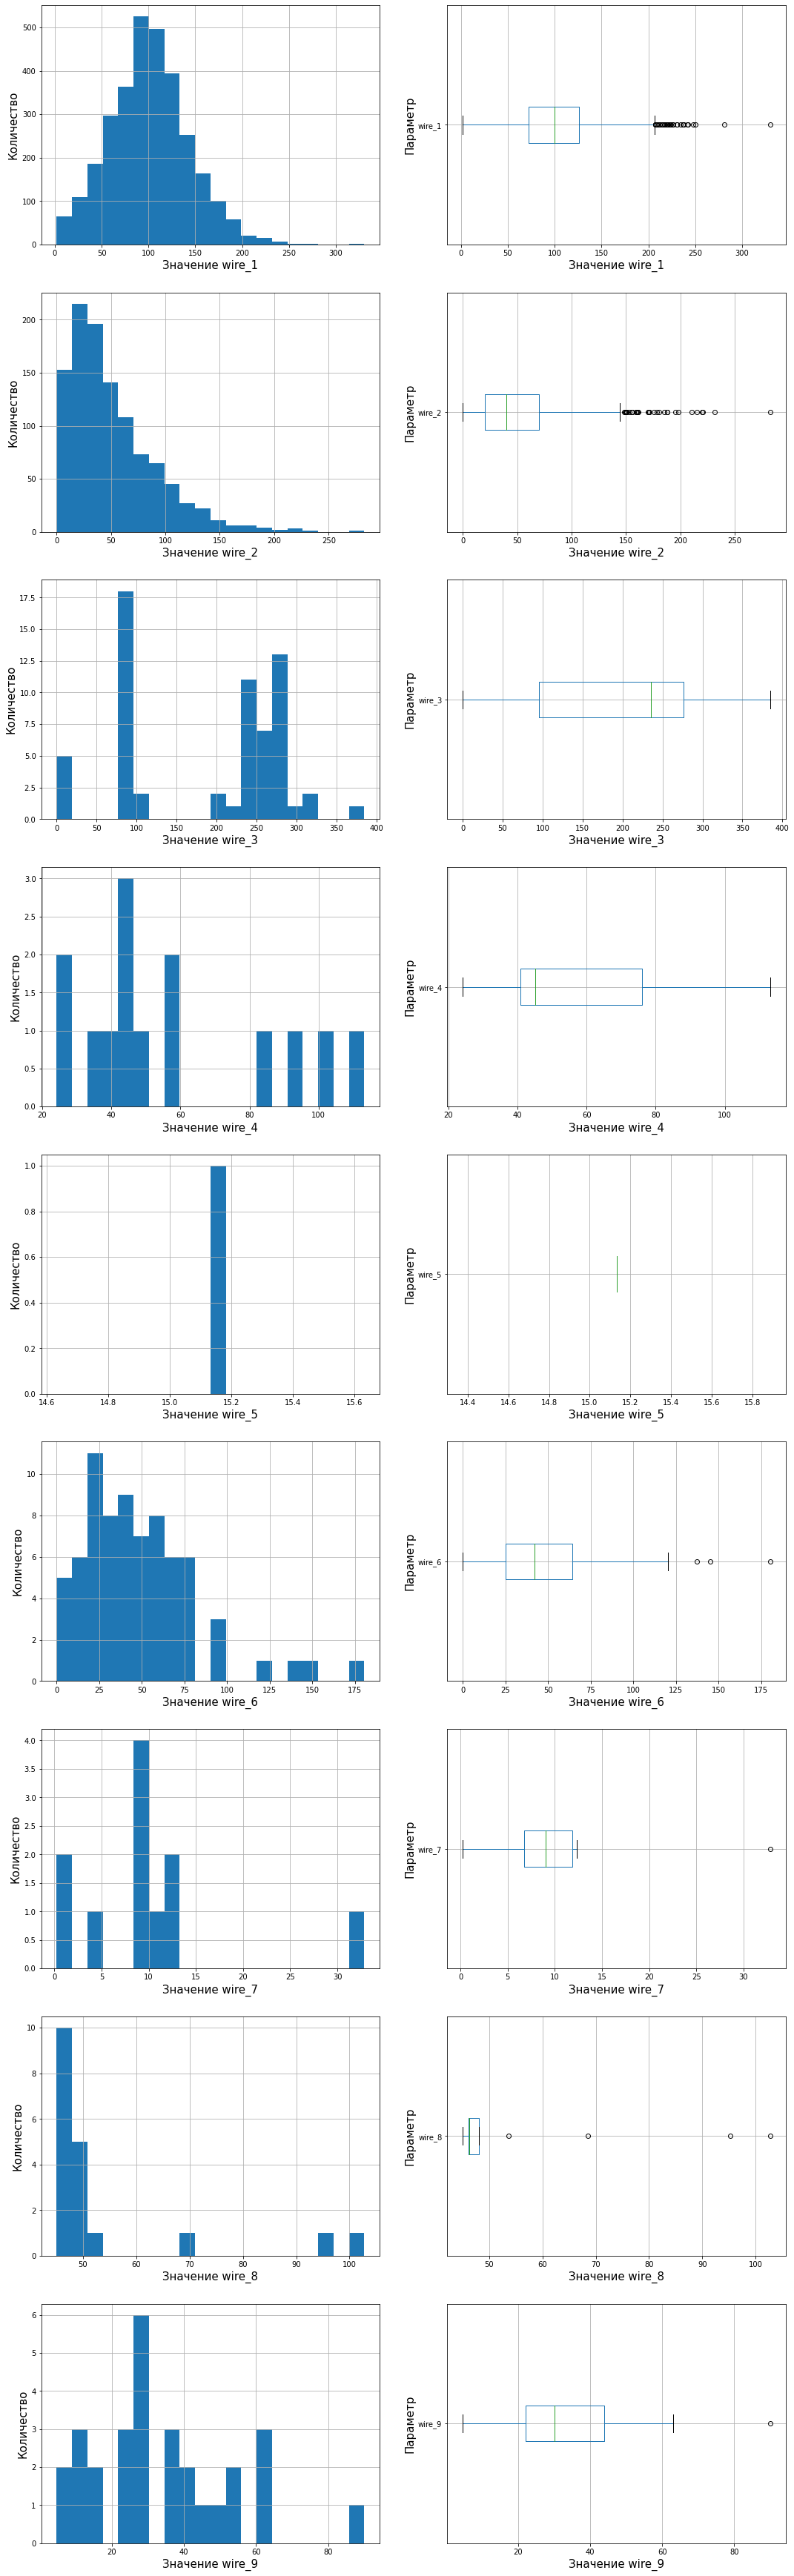

In [33]:
analysis(data_wire_new, 'data_wire_new', 'yes')

Много пропусков, заменим их нулями, т.к. остутсвие каких-либо данных в этом датафрейме означает, что этот материал не добавляли:

In [34]:
# заполнение пропусков нулями
data_wire_new = data_wire_new.fillna(0)

In [35]:
# вывод количества пропусков в столбцах
data_wire_new.isnull().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропусков нет.

Вывод:
- материал `wire_1` присутствует почти во всех сплавах, материал `wire_2` всыпают уже меньше, остальные практически не засыпают;
- обработаны пропуски.

### Данные о проволочных материалах (время)

Посмотрим на анализ данных о проволочных материалах (время):

In [36]:
analysis(data_wire_time_new, 'data_wire_time_new', 'no')

Анализ временных данных в датафрейме: data_wire_time_new


,Доля пропусков,Самая раняя дата,Самая поздняя дата
wire_1,0.008439,2019-05-03 11:06:19,2019-09-06 17:10:06
wire_2,0.649789,2019-05-03 13:15:34,2019-09-06 07:35:40
wire_3,0.979552,2019-05-04 04:34:27,2019-09-02 07:14:44
wire_4,0.995456,2019-05-07 15:19:17,2019-08-13 03:16:45
wire_5,0.999675,2019-08-13 06:14:30,2019-08-13 06:14:30
wire_6,0.976306,2019-05-07 14:46:05,2019-08-18 19:10:56
wire_7,0.996430,2019-07-27 05:49:05,2019-08-13 10:25:22
wire_8,0.993833,2019-05-14 11:29:24,2019-08-16 08:56:23
wire_9,0.990587,2019-05-04 17:21:27,2019-09-03 12:55:23


Cоздадим новый признак `wire_steel_grade`, обозначающий "условную" марку стали (1, 2, 3...) (марка стали - это уникальный набор добавок):

In [37]:
# создание нового признака wire_steel_grade
data_wire_time_new['wire_steel_grade'] = new_features(data_wire_time_new)

Количество уникальных марок стали: 24


In [38]:
print(f'Количество пропусков в столбце wire_steel_grade: {data_wire_time_new["wire_steel_grade"].isnull().sum()}')

Количество пропусков в столбце wire_steel_grade: 0


Пропусков в столбце с новым признаком нет.

Вывод:
- даты партий в тех же пределах, что и в `data_arc_new` с 3 мая 2019 по 6 сентября 2019;
- был создан новый признак марки стали `wire_steel_grade`;
- пропуски заполнять нет необходимости, в дальнейшем будет использоваться только новый признак.

### Общий вывод

Вывод:
- названия столбцов были приведены к змеиному регистру;
- были изменены типы данных на корректные;
- добавлено шесть новых признаков;
- обработаны пропуски и аномалии там, где это было необходимо;
- при анализе данных было выявлено слудующее:
    - партии были сделаныв в период с 3 мая 2019 по 6 сентября 2019;
    - больше всего в партии добавляли добавки `bulk_12`, `bulk_14` и `bulk_15` и проволочный материал `wire_1`.

## Объединение данных

Объединение данных начнем с преобразования датафрейма `data_temp_new`, сведем данные по столбцу `key` и вычислим время первого и последнего замера в партии:

In [39]:
# сведение партий по времени первого и последнего замера
time_min = data_temp_new.pivot_table(index='key', 
                                     values='time', 
                                     aggfunc='min')

time_max = data_temp_new.pivot_table(index='key', 
                                     values='time', 
                                     aggfunc='max')

In [40]:
# перевод индекса в столбец
time_min.reset_index(inplace=True)
time_max.reset_index(inplace=True)

In [41]:
# переименование столбцов
time_min.columns = ['key', 'time']
time_max.columns = ['key', 'time']

print(f'Размер датафрейма time_min: {time_min.shape}\nРазмер датафрейма time_max: {time_max.shape}')

Размер датафрейма time_min: (3216, 2)
Размер датафрейма time_max: (3216, 2)


Теперь присоединим соответствующую температуру в датафреймы, с помошью метода `merge` по столбцу `time`, т.к. даты не повторяются:

In [42]:
# присоединение температуры
time_min = time_min.merge(data_temp_new[['time', 'temp']], on='time', how='left')
time_max = time_max.merge(data_temp_new[['time', 'temp']], on='time', how='left')

In [43]:
# переименование столбцов
time_min.columns = ['key', 'start_time', 'start_temp']
time_max.columns = ['key', 'end_time', 'end_temp']

print(f'Размер датафрейма time_min: {time_min.shape}\nРазмер датафрейма time_max: {time_max.shape}')

Размер датафрейма time_min: (3216, 3)
Размер датафрейма time_max: (3216, 3)


Все отлично, теперь объединим оба датафрейма:

In [44]:
# объединение в промежуточный финальный датафрейм
data_inter_final = time_min.merge(time_max, on='key', how='inner')

print(f'Размер датафрейма data_inter_final: {data_inter_final.shape}')

Размер датафрейма data_inter_final: (3216, 5)


Получилось 4 признака и `key`.

Теперь уберем данные с некорректной температурой при первом замере `start_temp` (меньше 1300 градусов) и партии с пропусками замеров температуры:

In [45]:
# получение среза без выбросов начальной температуры
data_inter_final = data_inter_final.query('start_temp > 1300')

In [46]:
# удаление строк с пропусками
data_inter_final = data_inter_final.dropna().reset_index(drop=True)

print(f'Размер датафрейма data_inter_final после удаления выбросов в start_temp и удаления пропусков: {data_inter_final.shape}')

Размер датафрейма data_inter_final после удаления выбросов в start_temp и удаления пропусков: (2473, 5)


Датафрейм уменьшился на 743 строки, теперь сведем данные об электродах:

In [47]:
# сведение данных об электродах
data_arc_new_pivot = data_arc_new.pivot_table(index='key',
                                              values=['start_heating', 'end_heating', 'active_power', 'reactive_power',
                                                      'full_power', 'cos_fi', 'duration_heating', 'energy'],
                                              aggfunc={'start_heating': 'min', 
                                                      'end_heating': 'max', 
                                                      'active_power': 'sum', 
                                                      'reactive_power': 'sum',
                                                      'full_power': 'sum', 
                                                      'duration_heating': 'sum', 
                                                      'energy': 'sum', 
                                                      'cos_fi': 'mean'})

In [48]:
# перевод индекса в столбец
data_arc_new_pivot.reset_index(inplace=True)

print(f'Размер датафрейма data_arc_new_pivot: {data_arc_new_pivot.shape}')

Размер датафрейма data_arc_new_pivot: (3214, 9)


Все хорошо, добавим эти признаки к датафрейму `data_inter_final`:

In [49]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_arc_new_pivot, on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_arc_new_pivot: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_arc_new_pivot: (2471, 13)


Добавилось еще 8 признаков и исключилось еще две партии.

Теперь проведем проверку корректности замеров температуры, создадим столбец `check` со значением 1, еcли первый замер температуры `start_time` меньше времени начала первого нагрева `start_heating` и последний замер `end_time` сделан после окончания нагрева `end_heating`:

In [50]:
# создание столбца с проверкой временных рамок
data_inter_final['check'] = np.where((data_inter_final['start_time'] < data_inter_final['start_heating']) &
                                     (data_inter_final['end_time'] > data_inter_final['end_heating']), 
                                     '1',
                                     np.nan)

print(f'Количество пропусков в столбце check: {data_inter_final["check"].isnull().sum()}')

Количество пропусков в столбце check: 0


Все замеры температуры были сделаны в корректное время, данные о времени в дальнейшем не нужны, удалим их как и столбец `check`:

In [51]:
# удаление не нужных признаков
data_inter_final = data_inter_final.drop(['start_time', 'end_time', 'end_heating', 'start_heating', 'check'], axis=1)

print(f'Размер датафрейма data_inter_final после удаления пропусков: {data_inter_final.shape}')

Размер датафрейма data_inter_final после удаления пропусков: (2471, 9)


Количество признаков сократилось до 8.

Теперь добавим остальные признаки из оставшихся датафреймов:

In [52]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_bulk_new, on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_bulk_new: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_bulk_new: (2403, 24)


In [53]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_bulk_time_new[['key', 'bulk_steel_grade']], on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_bulk_time_new: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_bulk_time_new: (2403, 25)


In [54]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_gas_new, on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_gas_new: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_gas_new: (2401, 26)


In [55]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_wire_new, on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_wire_new: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_wire_new: (2325, 35)


In [56]:
# добавление признаков в промежуточный финальный датафрейм
data_inter_final = data_inter_final.merge(data_wire_time_new[['key', 'wire_steel_grade']], on='key', how='inner')

print(f'Размер датафрейма data_inter_final после присоединения data_wire_time_new: {data_inter_final.shape}')

Размер датафрейма data_inter_final после присоединения data_wire_time_new: (2325, 36)


Все данные объединены, получилось 35 признаков и 2325 партии.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Для начала посмотрим на количество пропусков по столбцам:

In [57]:
print(f'Количество пропусков по столбцам:\n{data_inter_final.isnull().sum()}')

Количество пропусков по столбцам:
key                 0
start_temp          0
end_temp            0
active_power        0
cos_fi              0
duration_heating    0
energy              0
full_power          0
reactive_power      0
bulk_1              0
bulk_2              0
bulk_3              0
bulk_4              0
bulk_5              0
bulk_6              0
bulk_7              0
bulk_8              0
bulk_9              0
bulk_10             0
bulk_11             0
bulk_12             0
bulk_13             0
bulk_14             0
bulk_15             0
bulk_steel_grade    0
gas                 0
wire_1              0
wire_2              0
wire_3              0
wire_4              0
wire_5              0
wire_6              0
wire_7              0
wire_8              0
wire_9              0
wire_steel_grade    0
dtype: int64


Отлично, пропусков нет.

Посмотрим на количество уникальных значений признаков:

In [58]:
print(f'Количество уникальных значений по столбцам:\n{data_inter_final.nunique()}')

Количество уникальных значений по столбцам:
key                 2325
start_temp           133
end_temp              75
active_power        2325
cos_fi              2325
duration_heating    1036
energy              2325
full_power          2325
reactive_power      2324
bulk_1                38
bulk_2                13
bulk_3               265
bulk_4               199
bulk_5                43
bulk_6               189
bulk_7                14
bulk_8                 2
bulk_9                10
bulk_10               71
bulk_11               86
bulk_12              303
bulk_13               11
bulk_14              254
bulk_15              143
bulk_steel_grade     126
gas                 2325
wire_1              1810
wire_2               563
wire_3                36
wire_4                13
wire_5                 1
wire_6                43
wire_7                 5
wire_8                10
wire_9                22
wire_steel_grade      19
dtype: int64


Проволочный материал `wire_5` был только в одной партии и она, судя по одному уникальному значению, не попала в финальный датафрейм, удалим этот признак немного позже.

Теперь посмотрим на распределение остальных признаков, за исключением сыпучих и проволочных материалов (заполнение пропусков нулями в этих признаках мешают их адекватно проанализировать):

Анализ количественных данных в датафрейме: data_inter_final


,Доля пропусков,Самое низкое значение,Самое высокое значение
start_temp,0.0,1519.000000,1660.000000
end_temp,0.0,1541.000000,1653.000000
active_power,0.0,0.267676,12.375636
cos_fi,0.0,0.739789,0.857042
duration_heating,0.0,57.000000,4189.000000
full_power,0.0,0.331897,15.288271
reactive_power,0.0,0.196228,8.949049
energy,0.0,33.430208,4546.405812
gas,0.0,0.008399,77.995040
bulk_steel_grade,0.0,1.000000,127.000000



 Гистограммы и диаграммы размаха количественных признаков в data_inter_final


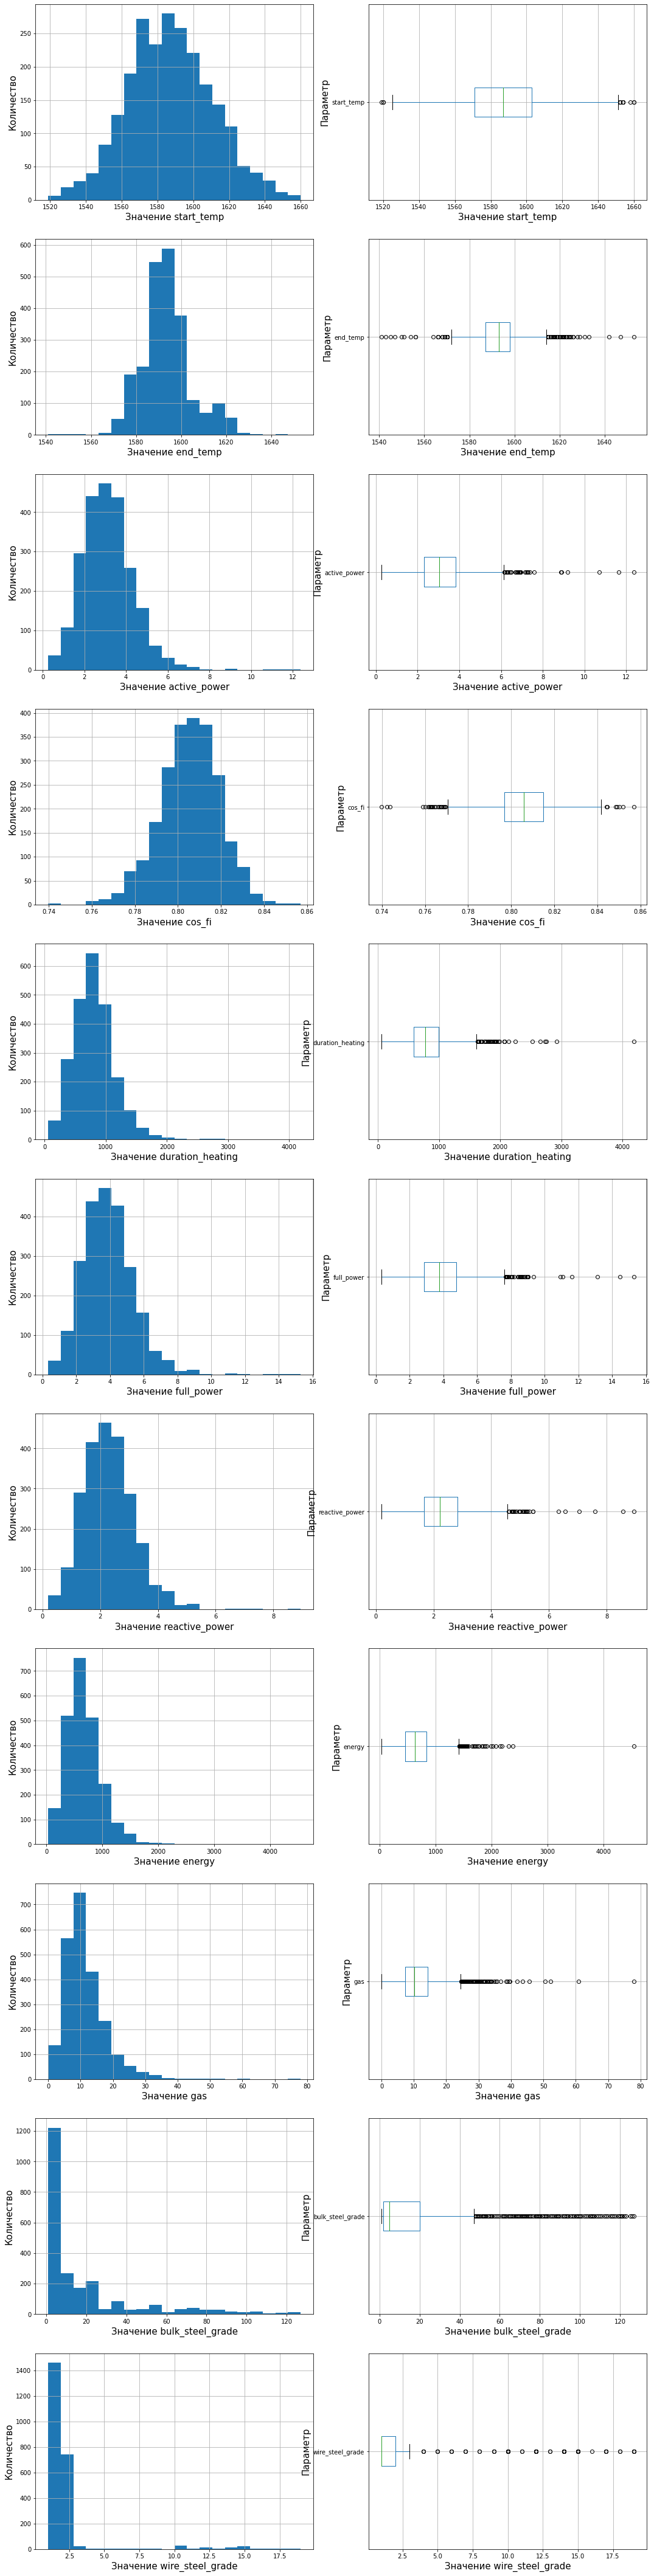

In [59]:
analysis(data_inter_final[['key', 'start_temp', 'end_temp', 'active_power', 'cos_fi', 'duration_heating',
                          'full_power', 'reactive_power', 'energy', 'gas', 'bulk_steel_grade', 'wire_steel_grade']], 
         'data_inter_final', 'no')

Данные выглядят нормально распределенными, кроме разве, что `start_temp` и `end_temp`, там есть небольшие вторые пики, и по данным марок стали, видно что всего пара марок стали делается чаще других.

Теперь удалим столбец `wire_5`, также удалим еще столбец `key`, который нужен был только для объединения данных:

In [60]:
data_inter_final = data_inter_final.drop(['key', 'wire_5'], axis=1)

print(f'Размер датафрейма data_inter_final после удаления признаков: {data_inter_final.shape}')

Размер датафрейма data_inter_final после удаления признаков: (2325, 34)


Посмотрим на матрицу корреляции, для этого воспользуемся коэффициентом корреляции Пирсона:

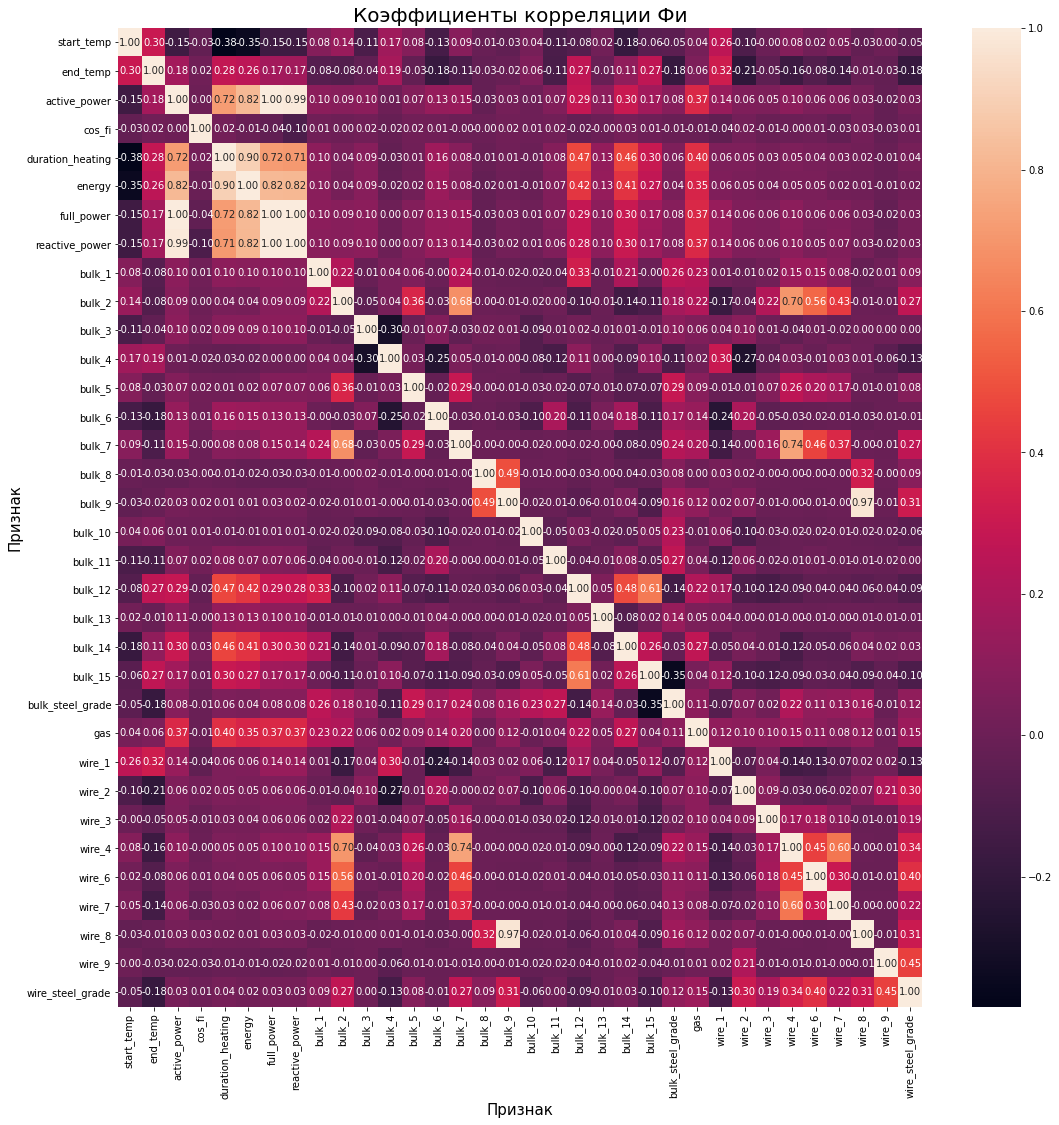

In [61]:
plt.subplots(figsize=(18, 18))
sns.heatmap(data_inter_final.corr(), 
            annot=True, 
            fmt=".2f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

Вывод по матрице корреляции:
- больше всех в целевым признаком `end_temp` коррелируют признаки проволочная добавка `wire_1` и начальная температура `start_temp` (коэффициент корреляции Пирсона 0,32 и 0,3 соответственно);
- немного меньше коррелируют признаки продолжительность нагрева `duration_heating`, энергия `enegry` и сыпучие добавки `bulk_12` и `bulk_15` (коэффициент корреляции Пирсона от 0,26 до 0,28);
- наблюдается мультиколлинеарность (коэффициент корреляции Пирсона больше 0,9) `active_power` с `reactive_power` и `full_power`;
- наблюдается мультиколлинеарность (коэффициент Фи больше 0,9) `wire_8` с `bulk_9`.

Так как `active_power` и `wire_8` сильнее коррелируют с целевым признаком удалим коррелирующие с ними признаки: `reactive_power`, `full_power`, `bulk_9`:

In [62]:
# избавление от мультиколлинеарности
data_final = data_inter_final.drop(['reactive_power', 'full_power', 'bulk_9'], axis=1)

print(f'Размер датафрейма data_final после удаления мультиколлинеарных признаков: {data_final.shape}')
print(f'Количество явных дубликатов в data_final: {data_final.duplicated().sum()}')

Размер датафрейма data_final после удаления мультиколлинеарных признаков: (2325, 31)
Количество явных дубликатов в data_final: 0


Вывод:
- были удалены неинформативные признаки, а также устранена мультиколлинеарность путем удаления признаков;
- выявлено, что больше всего коррелирует с целевым признаком проволочная добавка `wire_1` и начальная температура `start_temp`.

## Подготовка данных

Разделим финальный датасет `data_inter_final` на тренировочную и тестовую выборки в соотношении 3:1, выделив целевой признак `end_temp`:

In [63]:
# создание константы для фиксации результатов
RANDOM_STATE = 30624

In [64]:
# разделение на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(data_final.drop('end_temp', axis=1), 
                                                    data_final['end_temp'],
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [65]:
print('Размер выборки X_train:', X_train.shape)
print('Размер выборки y_train:', y_train.shape)
print('Размер выборки X_test:', X_test.shape)
print('Размер выборки y_test:', y_test.shape)

Размер выборки X_train: (1743, 30)
Размер выборки y_train: (1743,)
Размер выборки X_test: (582, 30)
Размер выборки y_test: (582,)


Данные разделены корректно, теперь займемся поиском аномалий в тренировочной выборке, аномалии будем искать двумя способами:
- с помощью модели `knn`:
- с помощью изолдяционного леса `IsolationForest`;

пересекающиеся аномалии, уберем из финального датафрейма:

In [66]:
# создание копии датафрейма для поиска аномалий
search_anomalies = X_train.copy()

In [67]:
# поиск аномалий с помощью KNN
model_knn = KNN()
model_knn.fit(search_anomalies)
search_anomalies['anomalies_knn'] = model_knn.predict(search_anomalies)

print("Количество аномалий (KNN): ", search_anomalies['anomalies_knn'].sum())

Количество аномалий (KNN):  148


In [68]:
# поиск аномалий с помощью IsolationForest
model_if = IsolationForest(n_estimators=100, random_state=RANDOM_STATE)
model_if.fit(search_anomalies)
search_anomalies['anomalies_if'] = model_if.predict(search_anomalies)

print("Количество аномалий (IsolationForest): ", search_anomalies.query('anomalies_if == -1')['anomalies_if'].count())

Количество аномалий (IsolationForest):  85


In [69]:
# поиск пересечений
search_anomalies['anomalies_knn_plus_if'] = search_anomalies['anomalies_knn'] + search_anomalies['anomalies_if']
matching_indexes = search_anomalies.query('anomalies_knn_plus_if == 0').index

print("Количество пересеченных аномалий: ", len(matching_indexes))

Количество пересеченных аномалий:  78


Получилось 78 аномалий, избавимся от них для более качественного обучения:

In [70]:
print(f'Размер датафрейма X_train до удаления аномалий: {X_train.shape}')

# удаление партий с аномалиями
X_train = X_train.drop(index=matching_indexes, axis=1)

print(f'Размер датафрейма X_train после удаления аномалий: {X_train.shape}')

Размер датафрейма X_train до удаления аномалий: (1743, 30)
Размер датафрейма X_train после удаления аномалий: (1665, 30)


In [71]:
print(f'Размер датафрейма y_train до удаления аномалий: {y_train.shape}')

# удаление партий с аномалиями
y_train = y_train.drop(index=matching_indexes, axis=1)

print(f'Размер датафрейма y_train после удаления аномалий: {y_train.shape}')

Размер датафрейма y_train до удаления аномалий: (1743,)
Размер датафрейма y_train после удаления аномалий: (1665,)


Данные готовы, можно приступать к обучению моделей!

## Обучение моделей машинного обучения

Создадим функцию c `pipeline` подготовки и обучения модели, для выбора лучшей модели будем использовать `GridSearchCV`:

In [72]:
# функция для выбора лучшей модели
def best_model (X_train, y_train, param_grid, scaler):
    # X_train - тренировочная выборка
    # y_train - целевой признак
    # param_grid - гиперпараметры пайплайна
    # scaler - необходимость масштабировать данные yes/no
    
    # список столбцов для масштабирования
    num_columns = X_train.select_dtypes('number').columns
    
    # создадим пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer([('num', StandardScaler(), num_columns)], remainder='passthrough')
    
    # создадим итоговый пайплайн:
    if scaler == 'yes':
        pipe_final = Pipeline([
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ])
    elif scaler == 'no':
        pipe_final = Pipeline([
            ('models', LinearRegression())
        ])
    else:
        print('Некорректный ввод параметра scaler')
        
    # выбор лучшей модели с помощью GridSearchCV
    gs = GridSearchCV(
        pipe_final, 
        param_grid=param_grid, 
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # обучение лучшей модели на тренировочной выборке
    gs.fit(X_train, y_train)
    
    # параметры лучшей модели
    params_best_model = (pd.DataFrame(gs.cv_results_)[['rank_test_score', 'params']]
                         .sort_values('rank_test_score')
                         .reset_index(drop=True)['params']
                         .loc[pd.DataFrame(gs.cv_results_).index[0]]
                        )


    print('Лучшая модель и её параметры:\n\n', params_best_model)
    print ('\nМетрика MAE лучшей модели на кросс-валидации:', -gs.best_score_.round(3))
    
    return gs.best_estimator_

Функция готова, можно приступать к обучению моделей.

### Модель LinearRegression

Создадим словарь с параметрами для модели `LinearRegression`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [73]:
# параметры для модели LinearRegression
param_grid_lr = [{
    'models':[LinearRegression()] # модель
}]

In [74]:
# получение лучшей модели и вывод получившейся метрики
best_model_lr = best_model(X_train, y_train, param_grid_lr, 'yes')

Лучшая модель и её параметры:

 {'models': LinearRegression()}

Метрика MAE лучшей модели на кросс-валидации: 6.148


Параметры и `MAE` лучшей модели `LinearRegression`:
- метод масштабирования - `StandardScaler`;
- метрика `MAE` лучшей модели на кросс-валидации: 6.148

### Модель DecisionTreeRegressor

Создадим словарь с параметрами для модели `DecisionTreeRegressor`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [75]:
# параметры для модели DecisionTreeRegressor
param_grid_dtr = [{
    'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)], # модель
    'models__max_depth': range(8, 15), # ограничение максимальной глубины дерева
    'models__max_features': ['sqrt', 'log2', None], # число листьев
    'models__min_samples_leaf': [1, 3, 5] # минимальное число объектов в листе
}]

In [76]:
# получение лучшей модели и вывод получившейся метрики
best_model_dtr = best_model(X_train, y_train, param_grid_dtr, 'no')

Лучшая модель и её параметры:

 {'models': DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, random_state=30624), 'models__max_depth': 8, 'models__max_features': None, 'models__min_samples_leaf': 5}

Метрика MAE лучшей модели на кросс-валидации: 7.224


Параметры и `MAE` лучшей модели `DecisionTreeRegressor`:
- максимальная глубина дерева `max_depth` - 8;
- число листьев `max_features` - `None`;
- минимальное число объектов в листе `min_samples_leaf` - 5;
- метрика `MAE` лучшей модели на кросс-валидации: 7.224

### Модель RandomForestRegressor

Создадим словарь с параметрами для модели `RandomForestRegressor`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [77]:
# параметры для модели RandomForestRegressor
param_grid_rfr = [{
    'models':[RandomForestRegressor(random_state=RANDOM_STATE)], # модель
    'models__n_estimators': range(200, 501, 50) # количество деревьев
}]

In [78]:
# получение лучшей модели и вывод получившейся метрики
best_model_rfr = best_model(X_train, y_train, param_grid_rfr, 'no')

Лучшая модель и её параметры:

 {'models': RandomForestRegressor(n_estimators=400, random_state=30624), 'models__n_estimators': 400}

Метрика MAE лучшей модели на кросс-валидации: 6.094


Параметры и `MAE` лучшей модели `RandomForestRegressor`:
- количество деревьев `n_estimators` - 400;
- метрика `MAE` лучшей модели на кросс-валидации: 6.094

### Модель LGBMRegressor

Создадим словарь с параметрами для модели `LGBMRegressor`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [79]:
# параметры для модели LGBMRegressor
param_grid_lgbmr = {
    'models':[LGBMRegressor(random_state=RANDOM_STATE)], # модель
    'models__learning_rate': [0.01, 0.1, 0.5] # скорость обучения
}

In [80]:
# получение лучшей модели и вывод получившейся метрики
best_model_lgbmr = best_model(X_train, y_train, param_grid_lgbmr, 'no')

Лучшая модель и её параметры:

 {'models': LGBMRegressor(random_state=30624), 'models__learning_rate': 0.1}

Метрика MAE лучшей модели на кросс-валидации: 6.247


Параметры и `MAE` лучшей модели `LGBMRegressor`:
- скорость обучения `learning_rate` - 0.1;
- метрика `MAE` лучшей модели на кросс-валидации: 6.247

### Модель CatBoostRegressor

Создадим словарь с параметрами для модели `CatBoostRegressor`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [81]:
# параметры для модели CatBoostRegressor
param_grid_cbr = {
    'models':[CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)], # модель
    'models__learning_rate': [0.01, 0.1, 0.5] # скорость обучения
}

In [82]:
# получение лучшей модели и вывод получившейся метрики
best_model_cbr = best_model(X_train, y_train, param_grid_cbr, 'no')

Лучшая модель и её параметры:

 {'models': <catboost.core.CatBoostRegressor object at 0x7f877680a1c0>, 'models__learning_rate': 0.01}

Метрика MAE лучшей модели на кросс-валидации: 5.999


Параметры и `MAE` лучшей модели `CatBoostRegressor`:
- скорость обучения `learning_rate` - 0.01;
- метрика `MAE` лучшей модели на кросс-валидации: 5.999

### Модель XGBRegressor

Создадим словарь с параметрами для модели `XGBRegressor`, посмотрим на получившуюся метрику при кросс-валидации и получим лучшую модель:

In [83]:
# параметры для модели XGBRegressor
param_grid_xgbr = {
    'models':[XGBRegressor(random_state=RANDOM_STATE)], # модель
    'models__learning_rate': [0.01, 0.1, 0.5], # скорость обучения
}

In [84]:
# получение лучшей модели и вывод получившейся метрики
best_model_xgbr = best_model(X_train, y_train, param_grid_xgbr, 'no')

Лучшая модель и её параметры:

 {'models': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=30624, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None), 'models__learning_rate': 0.1}

Метрика MAE лучшей модели на кросс-валидации: 6.128


Параметры и `MAE` лучшей модели `XGBRegressor`:
- скорость обучения `learning_rate` - 0.1;
- метрика `MAE` лучшей модели на кросс-валидации: 6.128

## Выбор лучшей модели

Сведем все результаты в одну таблицу и отсортируем по возрастанию метрики `MAE`:

In [85]:
# создание датафрейма с результатами
results = pd.DataFrame({'Модель МО':['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 
                                 'LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor'], 
                        'MAE при кросс-валидации':['6.148', '7.224', '6.094', '6.247', '5.999', '6.128']})

results.sort_values(by='MAE при кросс-валидации').reset_index(drop=True)

,Модель МО,MAE при кросс-валидации
0,CatBoostRegressor,5.999
1,RandomForestRegressor,6.094
2,XGBRegressor,6.128
3,LinearRegression,6.148
4,LGBMRegressor,6.247
5,DecisionTreeRegressor,7.224


Лучшей стала модель `CatBoostRegressor` со следующими параметрами и показателями:
- скорость обучения `learning_rate` - 0.01;
- метрика `MAE` при кросс-валидации - 5.999.

Посмотрим на важность признаков в модели `CatBoostRegressor`:

In [86]:
# получение важности признаков
importances = best_model_cbr.named_steps['models'].get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()

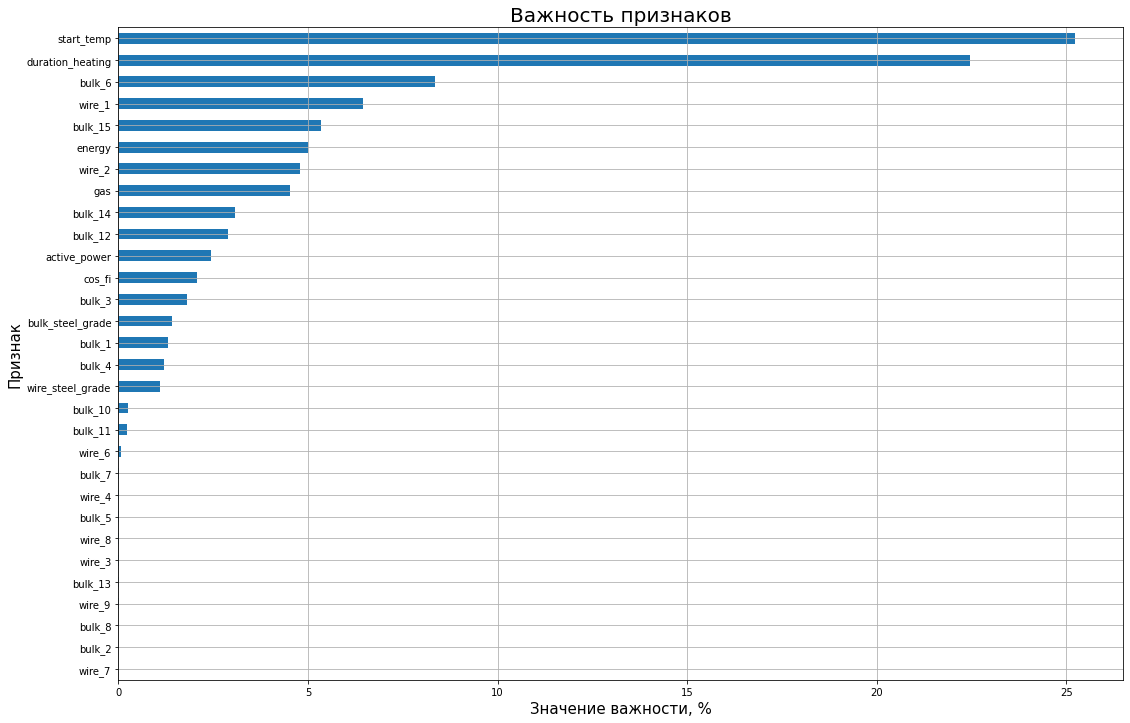

In [87]:
# построение графика важности признаков
feature_importances.plot.barh(grid=True, figsize=(18,12))
plt.title('Важность признаков', fontsize=20)
plt.xlabel('Значение важности, %', fontsize=15)
plt.ylabel('Признак', fontsize=15)
plt.show()

На графике видно, что:
- самым важным признаком оказалась начальная температура `start_temp` (больше 25%);
- дальше идет продолжительность нагрева `duration_heating` (22.5%);
- остальные признаки мало важны, значение важности у них меньше 8%.

Получим предсказания и значение метрики `MAE` на тестовой выборке:

In [88]:
# получение предсказаний на тестовой выборке
pred = best_model_cbr.predict(X_test)

print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, pred).round(3)}')

Метрика MAE на тестовой выборке: 5.929


Метрика `MAE` на тестовой выборке получилась - **5.929**, что удовлетворяет условию заказчика (`MAE` < 6.8).

Проверим лучшую модель на адекватность, сравним качество её предсказаний с качеством модели `DummyRegressor()`, которая предсказывает среднее значение тренировочной выборки:

In [89]:
# определение и обучение модели DummyRegressor
dummy = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

In [90]:
# получение предсказаний на тестовой выборке
pred_dummy = dummy.predict(X_test)

print(f'Метрика MAE на тестовой выборке модели DummyRegressor: {mean_absolute_error(y_test, pred_dummy).round(3)}')

Метрика MAE на тестовой выборке модели DummyRegressor: 7.909


Метрика получилась хуже, чем у лучшей модели, значит проект был сделан не зря.

## Общий вывод и рекомендации заказчику

В проекте "Предсказание конечной температуры сплава" проделана работа по загрузке данных и их изучению, а именно:
- были загружены данные по этапам обработки металла;
- было выявлено, что тип временных данных указан некорректно;
- было выявлено, что названия столбцов не соответствуют общепринятому змеиному регистру;
- количество уникальных партий во всех датафреймах различается.

Далее был проведен исследовательский анализ и первичная предобработка данных, в ходе чего:
- названия столбцов были приведены к змеиному регистру;
- были изменены типы данных на корректные;
- добавлено шесть новых признаков;
- обработаны пропуски и аномалии там, где это было необходимо.

Затем все данные были очищены от пропусков и объедены в один датафрейм, получилось 35 признаков и 2325 партий.

Потом был проведен еще исследовательский анализ и предобработка данных, в ходе которых:
- были удалены неинформативные признаки, а также устранена мультиколлинеарность путем удаления признаков, в результате осталось 30 признаков;
- выявлено, что больше всего коррелирует с целевым признаком проволочная добавка `wire_1` и начальная температура `start_temp`.

На 5 этапе:
- данные были разделены на тренировочную и тестовую выборки в соотношении 3:1.
- были удалены аномалии в тренировочной выборке, найденные с помощью модели `knn` и изолдяционного леса `IsolationForest`;

На тренировочных данных было обучено шесть моделей:
- `LinearRegression`;
- `DecisionTreeRegressor`;
- `RandomForestRegressor`;
- `LGBMRegressor`;
- `CatBoostRegressor`;
- `XGBRegressor`.

Выбор лучшей модели был сделан на основе наименьшей метрики `MAE` и лучшей оказалась модель `CatBoostRegressor` со следующими параметрами:
- скорость обучения `learning_rate` - 0.01;
- метрика `MAE` при кросс-валидации - 5.999.

Также из модели `CatBoostRegressor` были получены важности признаков и оказалось, что:
- самым важным признак - это начальная температура `start_temp` (больше 25%);
- дальше идет продолжительность нагрева `duration_heating` (22.5%);
- остальные признаки мало важны, значение важности у них меньше 8%.

Еще была проведена проверка на адекватность константной моделью `DummyRegressor`, модель `CatBoostRegressor` показала себя лучше её.

Метрика `MAE` на тестовой выборке модели `CatBoostRegressor` получилась - **5.929**, что удовлетворяет условию заказчика (`MAE` < 6.8).

**Рекомендации заказчику:**

Так как наиболее важными признаками для модели стали продолжительность нагрева и начальная температура, нужно работать именно с ними.

Для снижения потребления электроэнергии необходимо предпринять шаги к снижению времени нагрева при сохранении той же мощности, добиться этого можно путем снижения теплопотерь, т.е. повышению начальной температуры, ведь чтобы нагреть металл на пару градусов потребует меньше времени и электроэнергии, чем нагреть на пару десятков градусов.

Снизить теплопотери можно ускорением процессов происходщем между нагревами (химический анализ, засыпка материалов).